# Import các thư viện

In [1]:
# Thư viện cần thiết
import pandas as pd
import numpy as np
# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns
import csv
#Thư viện tiền xử lý
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.utils import to_categorical
# Thư viện dùng cho Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
# Machine learning model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc, confusion_matrix

# Tải dataset

In [2]:
file_path = "/content/drive/MyDrive/Firewall Log Dataset/Firewall logs dataset.csv"  # Thay đường dẫn nếu cần
df = pd.read_csv(file_path)
df.head(10)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
5,51465,443,39975,443,allow,3961,1595,2366,21,16,12,9
6,60513,47094,45469,47094,allow,320,140,180,6,7,3,3
7,50049,443,21285,443,allow,7912,3269,4643,23,96,12,11
8,52244,58774,2211,58774,allow,70,70,0,1,5,1,0
9,50627,443,16215,443,allow,8256,1674,6582,31,75,15,16


# Phân tích dataset

Số lượng dòng và cột

In [3]:
print("This Dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

This Dataset has 65532 rows and 12 columns


Thông tin về null và kiểu dữ liệu

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


Xóa khoảng trống trước tên cột

In [5]:
# Xóa khoảng trống trước tên cột
df.columns = df.columns.str.strip()

Xem phân phối nhãn

In [6]:
df['Action'].value_counts()

,count
Action,
allow,37640
deny,14987
drop,12851
reset-both,54


Hiển thị giá trị null

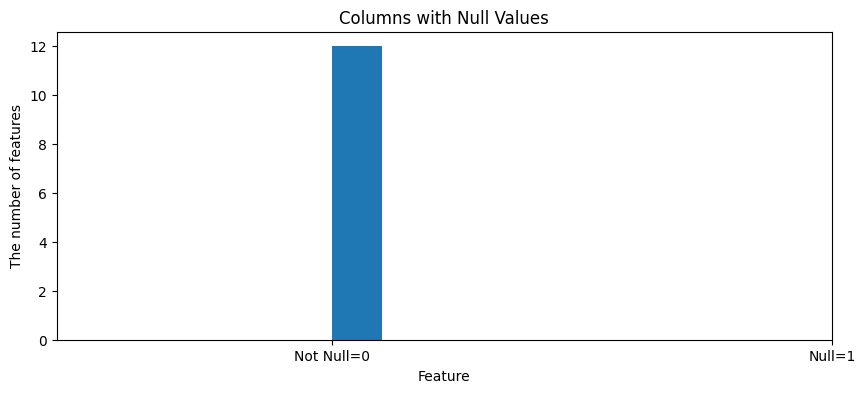

In [7]:
# Kiểm tra giá trị null trong dataset
plt.figure(1,figsize=( 10,4))
plt.hist( df.isna().sum())

# Set the title and axis labels
plt.xticks([0, 1], labels=['Not Null=0', 'Null=1'])
plt.title('Columns with Null Values')
plt.xlabel('Feature')
plt.ylabel('The number of features')
# Show the plot
plt.show()

Hiển thị số lượng giá trị null ở mỗi đặc trưng

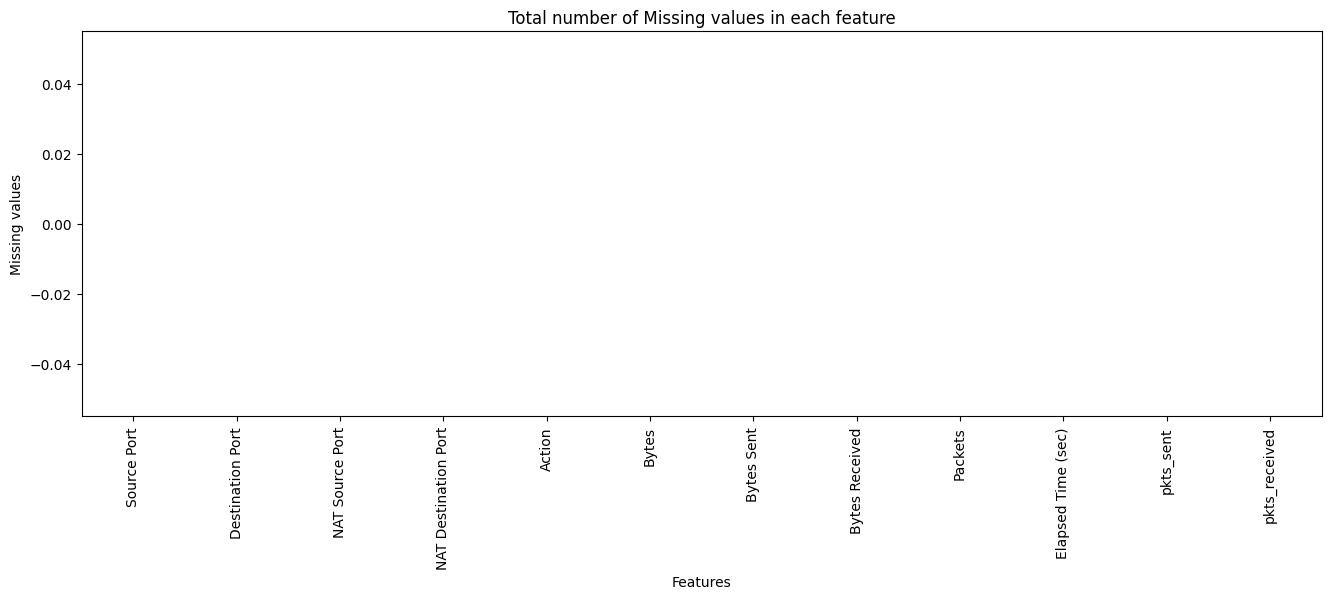

In [8]:
def plotMissingValues(dataframe):
    missing_values = dataframe.isnull().sum()  # Đếm giá trị null trong mỗi cột
    fig = plt.figure(figsize=(16, 5))
    missing_values.plot(kind='bar')
    plt.xlabel("Features")
    plt.ylabel("Missing values")
    plt.title("Total number of Missing values in each feature")
    plt.show()

plotMissingValues(df)

# Tiền xử lý

Xóa các cột bị trùng

In [9]:
def drop_duplicate_columns(df):
    duplicates = {}
    cols = df.columns
    to_drop = set()

    for i in range(len(cols)):
        if cols[i] in to_drop:
            continue
        for j in range(i + 1, len(cols)):
            if cols[j] in to_drop:
                continue
            # So sánh từng cột kỹ lưỡng (kể cả NaN)
            if df[cols[i]].equals(df[cols[j]]):
                duplicates[cols[j]] = cols[i]
                to_drop.add(cols[j])

    print("Cột bị trùng lặp:")
    for dup, orig in duplicates.items():
        print(f"- {dup} trùng với {orig}")

    return df.drop(columns=list(to_drop))

# Sử dụng:
df = drop_duplicate_columns(df)

Cột bị trùng lặp:


Xóa các dòng trùng lặp

In [10]:
df.drop_duplicates(inplace=True, keep='first')

Hiển thị lại số dòng và cột

In [11]:
print("This Dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

This Dataset has 57170 rows and 12 columns


In [12]:
# Giá trị đặc trưng của cột Label
df.loc[:,'Action'].unique()

array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)

Chuyển đổi nhãn thành dạng số
(allow:0; deny:1; drop:2; reset-both:3)

In [13]:
# Chọn các cột đặc trưng (features) và nhãn (label)
X = df.drop('Action', axis=1)
y = df['Action']

In [14]:
# Chuyển đổi nhãn thành số
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Chuyển 'allow', 'deny', 'drop', 'reset-both' thành số

# Hiển thị ánh xạ giữa nhãn gốc và số
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} => {i}")

allow => 0
deny => 1
drop => 2
reset-both => 3


Hiển thị biểu đồ phân phối nhãn

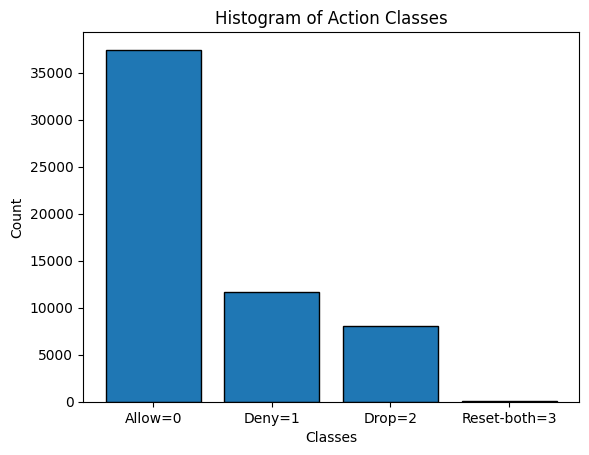

In [15]:
# Histogram với 4 bins cho nhãn 0, 1, 2, 3
plt.hist(df['Action'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor='black', rwidth=0.8)

# Đặt nhãn trục x tương ứng
plt.xticks([0, 1, 2, 3], labels=['Allow=0', 'Deny=1', 'Drop=2', 'Reset-both=3'])
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Histogram of Action Classes")
plt.show()

Tạo biểu đồ cho mỗi đặc trưng

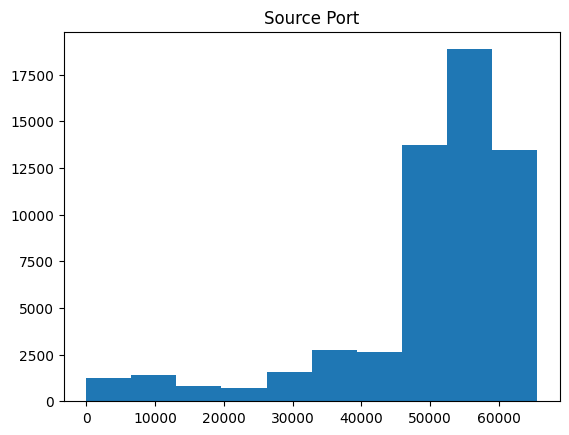

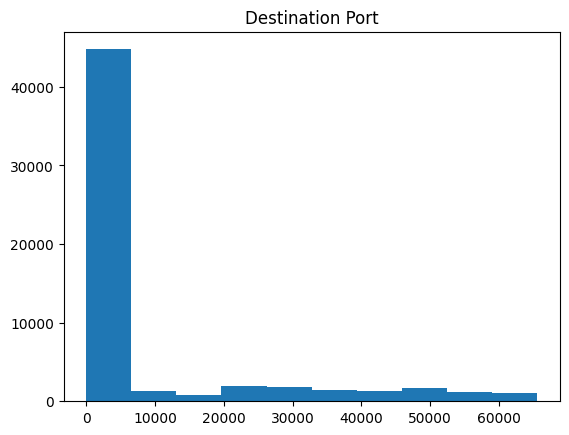

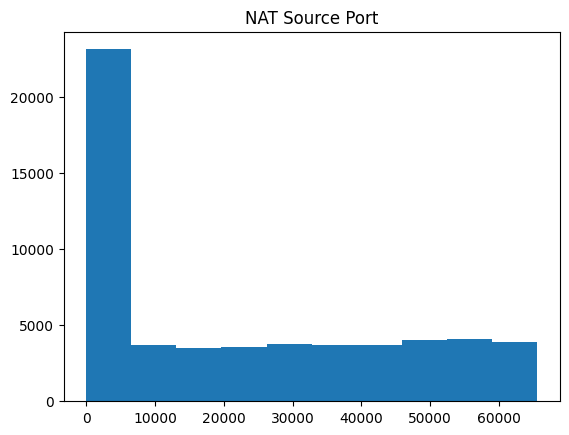

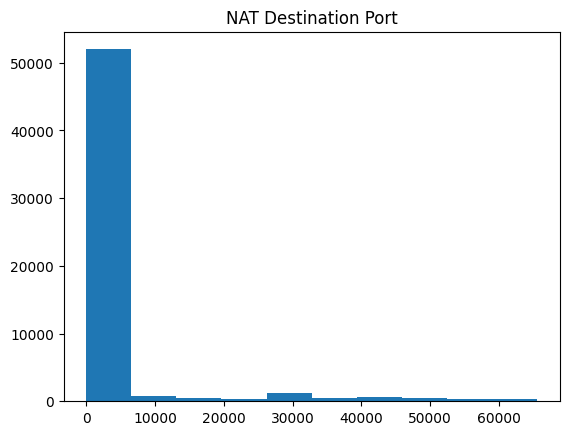

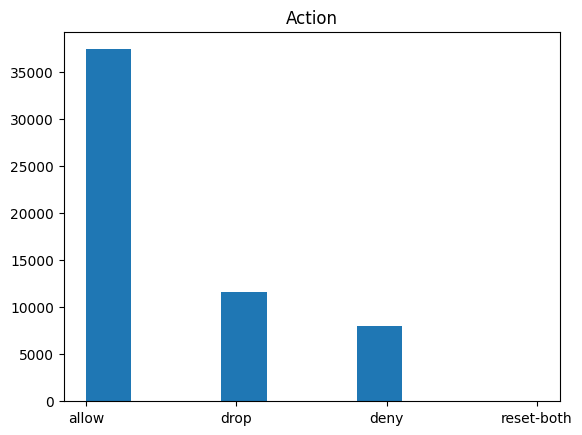

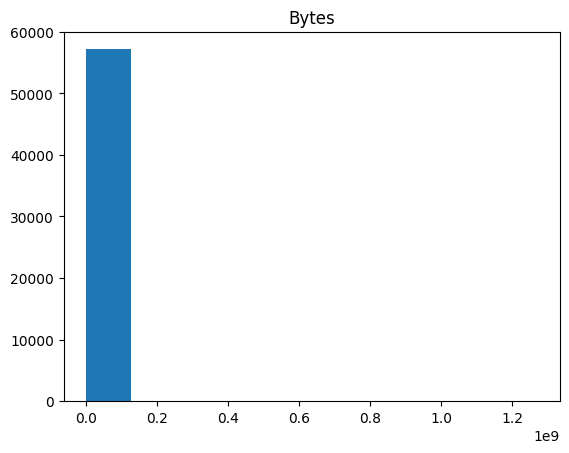

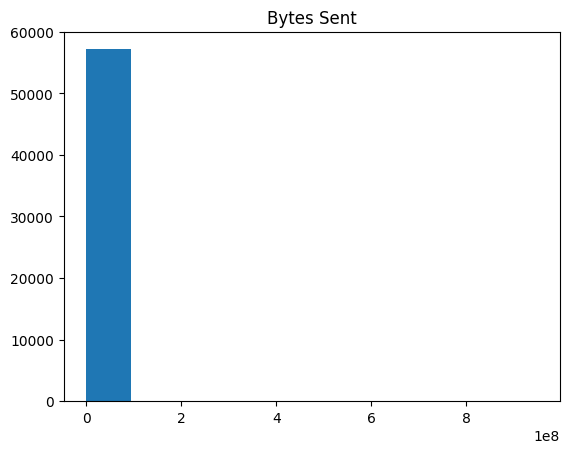

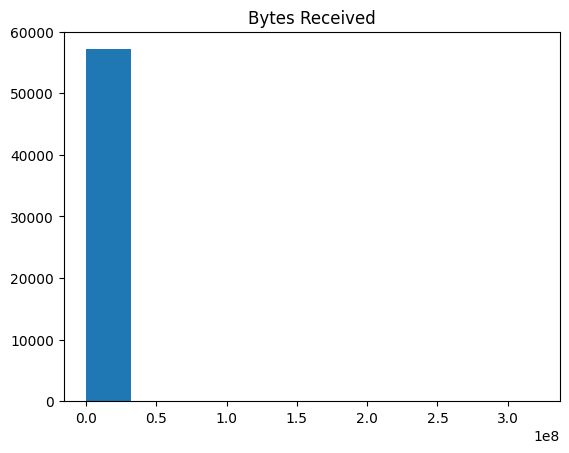

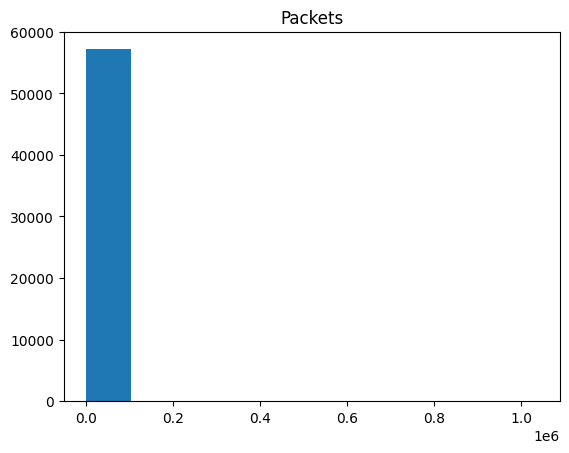

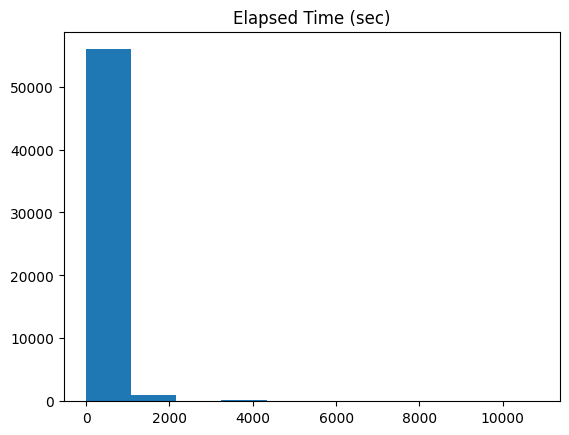

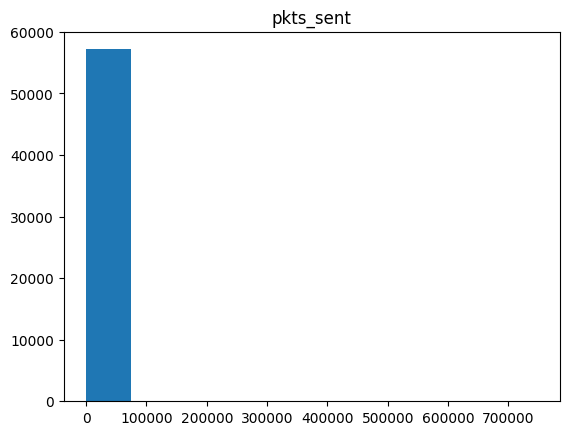

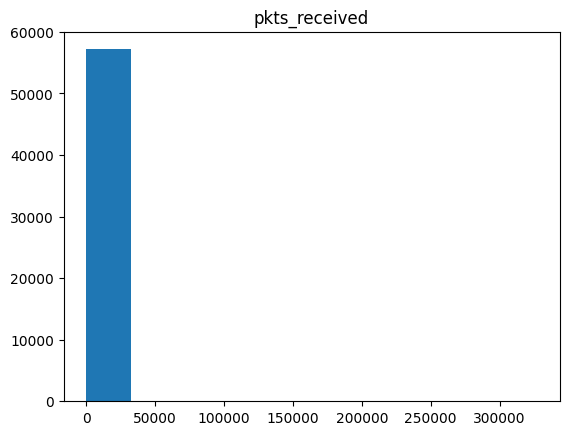

In [ ]:
# Tạo biểu đồ cho mỗi đặc trưng
plt.figure(5)
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

# Chuẩn bị dữ liệu huấn luyện mô hình

Chia tập train, test

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Sử dụng SMOTE để xử lý mất cân bằng dữ liệu

In [85]:
# Dùng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Số lượng mỗi nhãn sau khi dữ dụng SMOTE

In [86]:
# Kiểm tra số lượng các nhãn trong dữ liệu sau khi sử dụng SMOTE
print(Counter(y_resampled))

Counter({np.int64(1): 28079, np.int64(2): 28079, np.int64(0): 28079, np.int64(3): 28079})


## Huấn luyện mô hình Machine Learning

# Huấn luyện mô hình Random Forest

Huấn luyện

In [ ]:
# Huấn luyện Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_pred = rf_model.predict(X_test)

Hiển thị sắp xếp đặc trưng quan trọng và điểm quan trọng

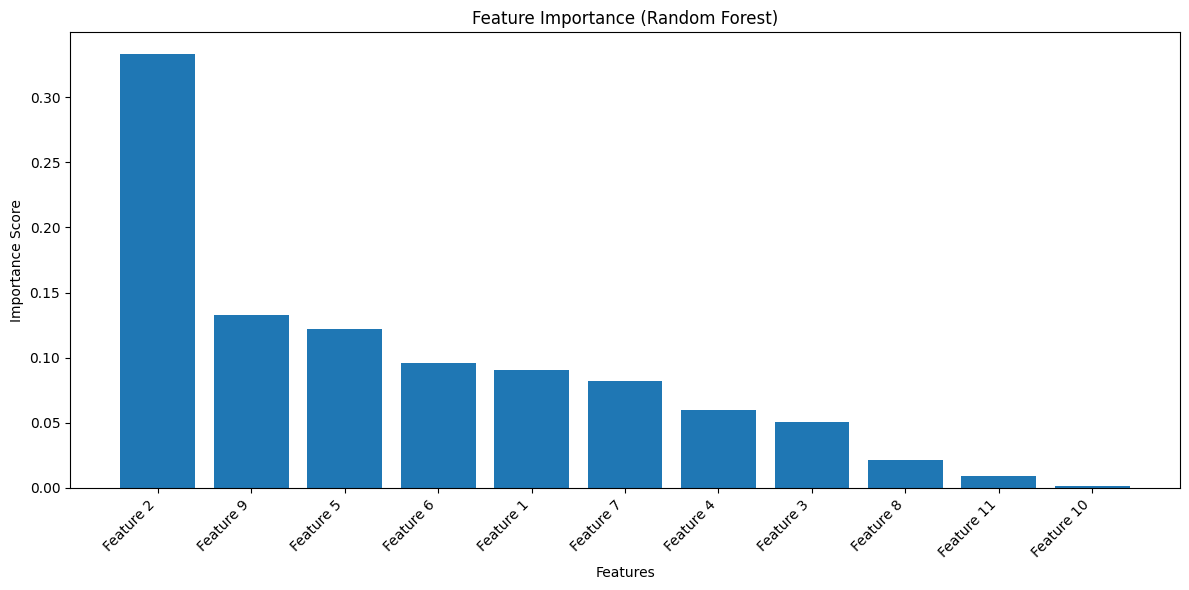

In [ ]:
# Giả sử bạn có 11 đặc trưng
feature_names = [f'Feature {i+1}' for i in range(X.shape[1])]

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

Vẽ cây huấn luyện

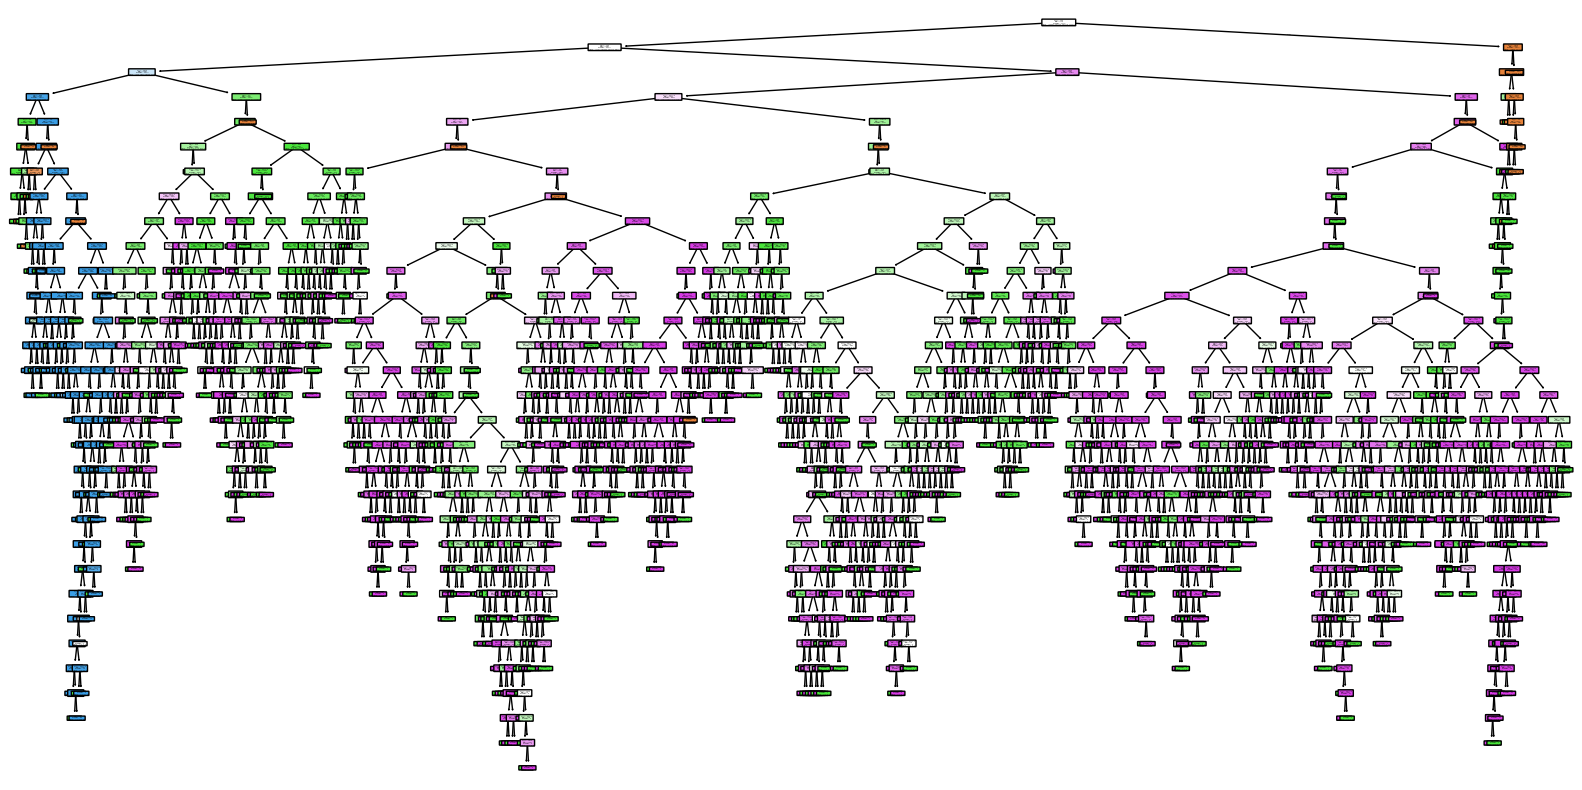

In [ ]:
from sklearn.tree import plot_tree

estimator = rf_model.estimators_[0]  # Chọn công cụ ước tính đầu tiên từ mô hình Random Forest

plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, rounded=True)
plt.show()

Hàm tạo ma trận nhầm lẫn

In [ ]:
# Hàm để tạo và hiển thị một ma trận confusion chi tiết
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Đánh giá mô hình

In [ ]:
# Tính các chỉ số
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')
rf_precision = precision_score(y_test, rf_pred, average='macro')
rf_recall = recall_score(y_test, rf_pred, average='macro')

# In kết quả
print('\n🔍 Random Forest Metrics:')
print(f'Accuracy:  {rf_accuracy:.4f}')
print(f'F1 Score:  {rf_f1:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall:    {rf_recall:.4f}')


🔍 Random Forest Metrics:
Accuracy:  0.9961
F1 Score:  0.8186
Precision: 0.7998
Recall:    0.8599


Ma trận nhầm lẫn

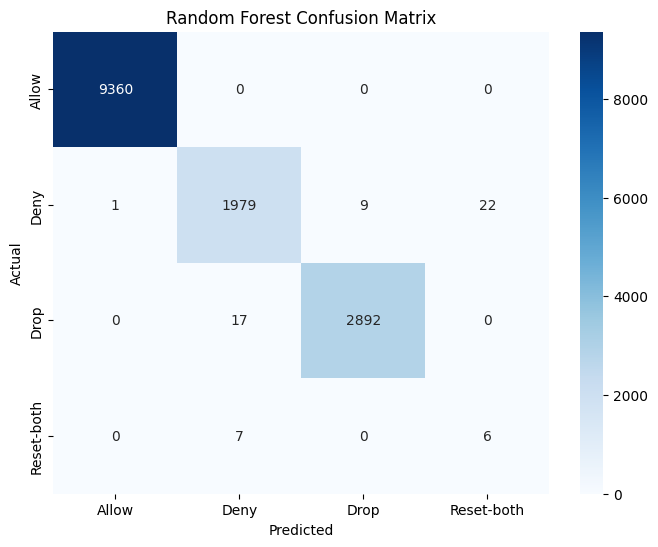

In [ ]:
# Ma trận confusion cho Random Forest
plot_confusion_matrix(y_test, rf_pred, ['Allow', 'Deny', 'Drop', 'Reset-both'], 'Random Forest Confusion Matrix')

# Huấn luyện mô hình XGBoost

Huấn luyện

In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)
xgb_pred = xgb_model.predict(X_test)

Đánh giá mô hình

In [ ]:
# Tính các chỉ số
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
xgb_precision = precision_score(y_test, xgb_pred, average='macro')
xgb_recall = recall_score(y_test, xgb_pred, average='macro')

# In kết quả
print('\n🔍 Random Forest Metrics:')
print(f'Accuracy:  {xgb_accuracy:.4f}')
print(f'F1 Score:  {xgb_f1:.4f}')
print(f'Precision: {xgb_precision:.4f}')
print(f'Recall:    {xgb_recall:.4f}')


🔍 Random Forest Metrics:
Accuracy:  0.9964
F1 Score:  0.8030
Precision: 0.7858
Recall:    0.8599


Ma trận nhầm lẫn

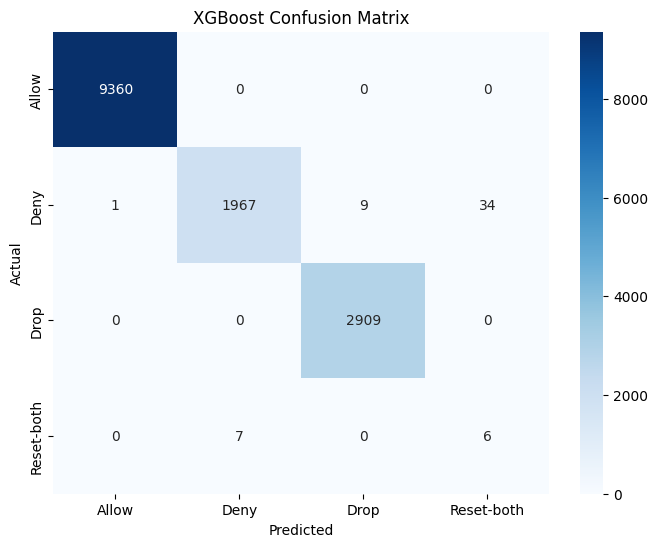

In [ ]:
# Ma trận confusion cho XGBoost
plot_confusion_matrix(y_test, xgb_pred, ['Allow', 'Deny', 'Drop', 'Reset-both'], 'XGBoost Confusion Matrix')

# Huấn luyện mô hình SVM

Chuẩn hóa dữ liệu

In [ ]:
# Do SVM nhạy cảm với dữ liệu lớn và không scale ==> chuẩn hóa dữ liệu
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

Huấn luyện

In [ ]:
# Fit LinearSVC với xác suất thông qua CalibratedClassifierCV
base_svc = LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)
svm_model = CalibratedClassifierCV(base_svc, cv=3)
svm_model.fit(X_resampled_scaled, y_resampled)
svm_pred = svm_model.predict(X_test_scaled)

Đánh giá mô hình

In [ ]:
# Tính các chỉ số
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='macro')
svm_precision = precision_score(y_test, svm_pred, average='macro')
svm_recall = recall_score(y_test, svm_pred, average='macro')

# In kết quả
print('\n🔍 Random Forest Metrics:')
print(f'Accuracy:  {svm_accuracy:.4f}')
print(f'F1 Score:  {svm_f1:.4f}')
print(f'Precision: {svm_precision:.4f}')
print(f'Recall:    {svm_recall:.4f}')


🔍 Random Forest Metrics:
Accuracy:  0.9461
F1 Score:  0.7016
Precision: 0.7431
Recall:    0.8389


Ma trận nhầm lẫn

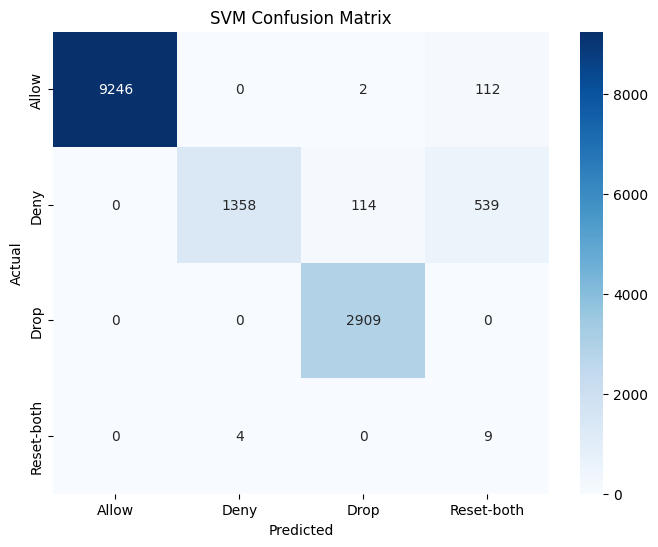

In [ ]:
# Ma trận confusion cho SVM
plot_confusion_matrix(y_test, svm_pred, ['Allow', 'Deny', 'Drop', 'Reset-both'], 'SVM Confusion Matrix')

# So sánh các mô hình

Tính AUC macro

In [ ]:
# Giả sử nhãn là 0, 1, 2, 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Predict probability
rf_proba = rf_model.predict_proba(X_test)
xgb_proba = xgb_model.predict_proba(X_test)
svm_proba = svm_model.predict_proba(X_test)

# Tính AUC macro
auc_rf = roc_auc_score(y_test_bin, rf_proba, multi_class='ovr', average='macro')
auc_xgb = roc_auc_score(y_test_bin, xgb_proba, multi_class='ovr', average='macro')
auc_svm = roc_auc_score(y_test_bin, svm_proba, multi_class='ovr', average='macro')


print("Random Forest AUC (macro):", auc_rf)
print("XGBoost AUC (macro):", auc_xgb)
print("LinearSVC AUC (macro):", auc_svm)

Random Forest AUC (macro): 0.9785111511191641
XGBoost AUC (macro): 0.9855032324939303
LinearSVC AUC (macro): 0.8129603935783405


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


Hiển thị biểu đồ AUC macro

In [ ]:
def plot_roc_curves(y_test_bin, model_probs, model_names):
    plt.figure(figsize=(8, 6))

    for probs, name in zip(model_probs, model_names):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_test_bin.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Tính macro AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(fpr))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(fpr)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(fpr)
        macro_auc = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_auc:.2f})')

    # Đường baseline
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


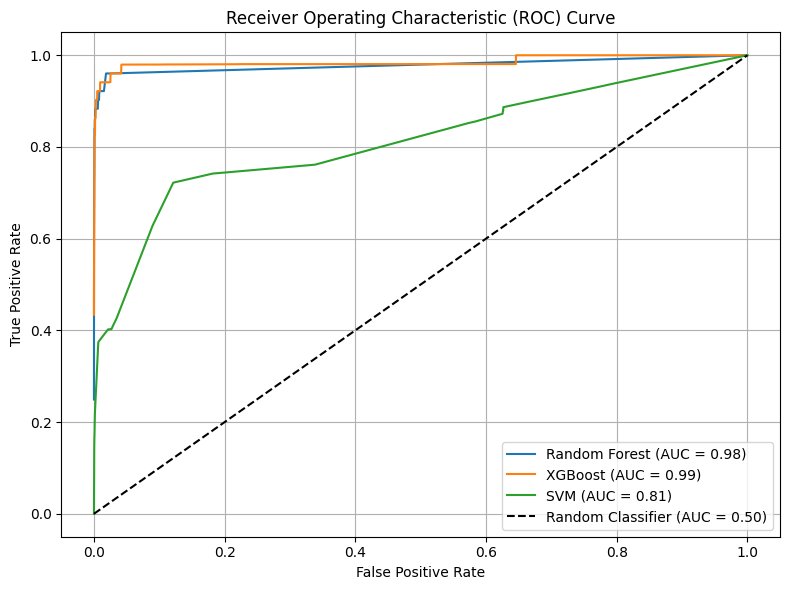

In [ ]:
# Gọi hàm:
plot_roc_curves(
    y_test_bin,
    [rf_proba, xgb_proba, svm_proba],
    ['Random Forest', 'XGBoost', 'SVM']
)

## Huấn luyện mô hình Deep Learning

# Huấn luyện mô hình LSTM

Standar Scale, Reshape X_train và Mã hóa one-pot y_train

In [87]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Reshape cho RNN hoặc CNN: (samples, time_steps, features)
# Với tabular, giả định mỗi sample là 1 chuỗi với n đặc trưng
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))  # time_steps = số đặc trưng

#Xử lý mã hóa one-hot
y_cat = to_categorical(y_resampled)

Tạo mô hình và huấn luyện

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_reshaped.shape[1], 1)))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(y_cat.shape[1], activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_reshaped, y_cat, epochs=15, batch_size=64, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7664 - loss: 0.5888 - val_accuracy: 0.1466 - val_loss: 1.8960
Epoch 2/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9221 - loss: 0.2300 - val_accuracy: 0.2322 - val_loss: 1.5824
Epoch 3/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9305 - loss: 0.2077 - val_accuracy: 0.3219 - val_loss: 1.3132
Epoch 4/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9328 - loss: 0.1951 - val_accuracy: 0.2353 - val_loss: 1.3505
Epoch 5/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9356 - loss: 0.1861 - val_accuracy: 0.2475 - val_loss: 1.3151
Epoch 6/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9372 - loss: 0.1780 - val_accuracy: 0.2883 - val_loss: 1.2189
Epoch 7/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9391 - loss: 0.1707 - val_accuracy: 0.2128 - val_loss: 1.3810
Epoch 8/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9402 -

Lưu mô hình dạng h5

In [33]:
lstm_model.save('/content/drive/MyDrive/Giám sát mạng - Cloud Defender/lstm_gsm_model.h5')

Lưu mô hình dạng keras

In [22]:
lstm_model.save('/content/drive/MyDrive/Giám sát mạng - Cloud Defender/lstm_gsm_model.keras')

Chuẩn hóa và reshape X_test

In [23]:
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

Dự doán tập X_test

In [24]:
# Dự đoán xác suất
lstm_pred_proba = lstm_model.predict(X_test_reshaped)

# Lấy nhãn dự đoán (class index)
lstm_pred = np.argmax(lstm_pred_proba, axis=1)

447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Ma trận nhầm lẫn

Classification Report:
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9360
        deny       0.99      0.92      0.95      2011
        drop       0.98      1.00      0.99      2909
  reset-both       0.05      0.38      0.09        13

    accuracy                           0.99     14293
   macro avg       0.75      0.83      0.76     14293
weighted avg       0.99      0.99      0.99     14293



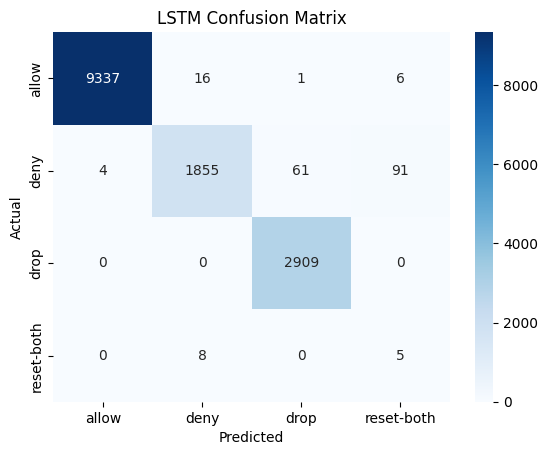

In [25]:
print("Classification Report:")
print(classification_report(y_test, lstm_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, lstm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()

# Huấn luyện mô hình CNN

Tạo và huấn luyện mô hình

In [26]:
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D

cnn_model = Sequential()
cnn_model.add(Input(shape=(X_reshaped.shape[1], 1)))
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(y_cat.shape[1], activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_reshaped, y_cat, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8162 - loss: 0.5257 - val_accuracy: 0.1538 - val_loss: 1.4557
Epoch 2/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9248 - loss: 0.2291 - val_accuracy: 0.2519 - val_loss: 1.1226
Epoch 3/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9289 - loss: 0.2113 - val_accuracy: 0.2240 - val_loss: 1.3069
Epoch 4/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9321 - loss: 0.2046 - val_accuracy: 0.2391 - val_loss: 1.2105
Epoch 5/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9360 - loss: 0.1929 - val_accuracy: 0.2351 - val_loss: 1.2283
Epoch 6/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9345 - loss: 0.1950 - val_accuracy: 0.2358 - val_loss: 1.3828
Epoch 7/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9361 - loss: 0.1904 - val_accuracy: 0.2275 - val_loss: 1.4768
Epoch 8/15
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9372 - loss: 0.1880 - 

Lưu mô hình dạng h5

In [ ]:
cnn_model.save('/content/drive/MyDrive/Giám sát mạng - Cloud Defender/cnn_gsm_model.h5')

Lưu mô hình dạng keras

In [ ]:
import keras
keras.saving.save_model(cnn_model, "/content/drive/MyDrive/Giám sát mạng - Cloud Defender/cnn_gsm_model.keras")

Dự đoán tập X_test

In [28]:
# Dự đoán xác suất
cnn_pred_proba = cnn_model.predict(X_test_reshaped)

# Lấy nhãn dự đoán (class index)
cnn_pred = np.argmax(cnn_pred_proba, axis=1)

447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Ma trận nhầm lẫn

Classification Report:
              precision    recall  f1-score   support

       allow       1.00      0.98      0.99      9360
        deny       0.97      0.97      0.97      2011
        drop       0.96      1.00      0.98      2909
  reset-both       0.03      0.15      0.05        13

    accuracy                           0.98     14293
   macro avg       0.74      0.78      0.75     14293
weighted avg       0.99      0.98      0.99     14293



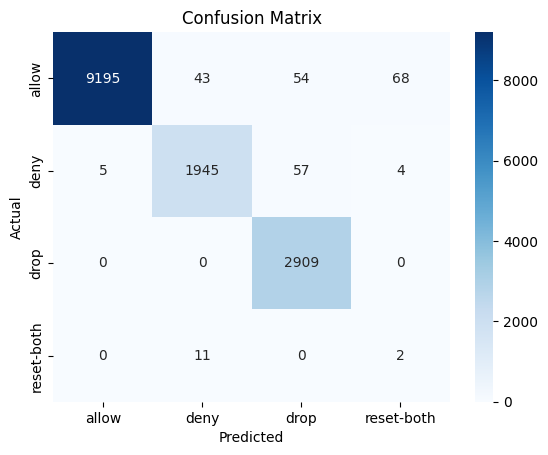

In [29]:
print("Classification Report:")
print(classification_report(y_test, cnn_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, cnn_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Dự đoán thử 1 tập dữ liệu ảo

Lưu scaler

In [88]:
import joblib
# Lưu scaler vào file
joblib.dump(scaler, '/content/drive/MyDrive/Giám sát mạng - Cloud Defender/scaler_model.pkl')

['/content/drive/MyDrive/Giám sát mạng - Cloud Defender/scaler_model.pkl']

load scaler

In [89]:
# Tải scaler đã lưu từ file
loaded_scaler = joblib.load('/content/drive/MyDrive/Giám sát mạng - Cloud Defender/scaler_model.pkl')

load mô hình cnn từ tệp h5

In [90]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/Giám sát mạng - Cloud Defender/Deep Learning/cnn_gsm_model.h5")

# Dự đoán bằng numarr

Chuẩn hóa đầu vào từ numarr

In [91]:
input_model = [
    [49242, 11108, 16951, 2733, 1346739, 326810, 275118, -379, 27, 570, -301],
    [48628, 8696, 16569, 2227, -1147619, 415306, 273259, 161, 59, 57, 187],
    [50987, 10620, 21165, 3411, -34019, -23982, 224678, -76, 62, 325, 86],
    [50320, 10377, 21312, 2277, -454828, -50347, -86300, 1557, 26, 478, 121],
    [50492, 13667, 18694, 2913, 341465, 306074, 266137, -257, 83, -125, 32]
    ]
input_model_scaled = loaded_scaler.transform(input_model)
input_model_reshaped = input_model_scaled.reshape((input_model_scaled.shape[0], input_model_scaled.shape[1], 1))

model.predict(input_model_reshaped)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


array([[4.3272756e-02, 5.9666842e-02, 0.0000000e+00, 8.9706039e-01],
       [3.6015558e-06, 6.3468808e-01, 0.0000000e+00, 3.6530831e-01],
       [7.2036779e-01, 2.4661010e-02, 0.0000000e+00, 2.5497118e-01],
       [4.1493233e-03, 4.7879063e-02, 0.0000000e+00, 9.4797158e-01],
       [2.6493635e-02, 7.7994801e-02, 0.0000000e+00, 8.9551157e-01]],
      dtype=float32)

hiện thị kết quả dự đoán

In [92]:
predicted_class = np.argmax(model.predict(input_model_reshaped), axis=1)

print(predicted_class)

labels = ["Allow", "Deny", "Drop", "Reset-both"]
for pred in predicted_class:
    print("Kết quả dự đoán:", labels[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[3 1 0 3 3]
Kết quả dự đoán: Reset-both
Kết quả dự đoán: Deny
Kết quả dự đoán: Allow
Kết quả dự đoán: Reset-both
Kết quả dự đoán: Reset-both


# Dự đoán bằng csv

Load csv cần dự đoán

In [94]:
input_csv = pd.read_csv('/content/drive/MyDrive/Firewall Log Dataset/firewall-logs-testtest.csv')
input_csv.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,49242,11108,16951,2733,1346739,326810,275118,-379,27,570,-301
1,48628,8696,16569,2227,-1147619,415306,273259,161,59,57,187
2,50987,10620,21165,3411,-34019,-23982,224678,-76,62,325,86
3,50320,10377,21312,2277,-454828,-50347,-86300,1557,26,478,121
4,50492,13667,18694,2913,341465,306074,266137,-257,83,-125,32


Chuẩn hóa đầu vào

In [95]:
input_csv_scaled = loaded_scaler.transform(input_csv)
input_csv_reshaped = input_csv_scaled.reshape((input_csv_scaled.shape[0], input_csv_scaled.shape[1], 1))

model.predict(input_csv_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[4.3272756e-02, 5.9666842e-02, 0.0000000e+00, 8.9706039e-01],
       [3.6015558e-06, 6.3468808e-01, 0.0000000e+00, 3.6530831e-01],
       [7.2036779e-01, 2.4661010e-02, 0.0000000e+00, 2.5497118e-01],
       [4.1493233e-03, 4.7879063e-02, 0.0000000e+00, 9.4797158e-01],
       [2.6493635e-02, 7.7994801e-02, 0.0000000e+00, 8.9551157e-01]],
      dtype=float32)

Kết quả dự đoán

In [96]:
predicted_class = np.argmax(model.predict(input_model_reshaped), axis=1)

print(predicted_class)

labels = ["Allow", "Deny", "Drop", "Reset-both"]
for pred in predicted_class:
    print("Kết quả dự đoán:", labels[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[3 1 0 3 3]
Kết quả dự đoán: Reset-both
Kết quả dự đoán: Deny
Kết quả dự đoán: Allow
Kết quả dự đoán: Reset-both
Kết quả dự đoán: Reset-both


# So sánh mô hình Deep Learning

Tính AUC với One vs Rest

In [30]:
# Tính AUC cho mô hình LSTM
lstm_auc = roc_auc_score(y_test, lstm_pred_proba, multi_class='ovr')

# Tính AUC cho mô hình CNN
cnn_auc = roc_auc_score(y_test, cnn_pred_proba, multi_class='ovr')

# In kết quả AUC
print(f'AUC của mô hình LSTM: {lstm_auc}')
print(f'AUC của mô hình CNN: {cnn_auc}')

AUC của mô hình LSTM: 0.9860241486614543
AUC của mô hình CNN: 0.9878279588313257


Biểu đồ ROC cho LSTM

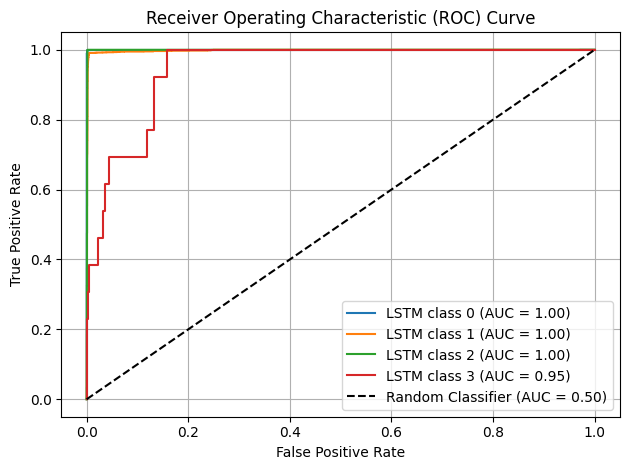

In [31]:
classes = [0, 1, 2, 3]
y_test_bin = label_binarize(y_test, classes=classes)

for i in range(len(classes)):
    fpr_lstm, tpr_lstm, _ = roc_curve(y_test_bin[:, i], lstm_pred_proba[:, i])
    plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM class {i} (AUC = {roc_auc_score(y_test_bin[:, i], lstm_pred_proba[:, i]):.2f})')

# Đường baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Biểu đồ ROC cho CNN

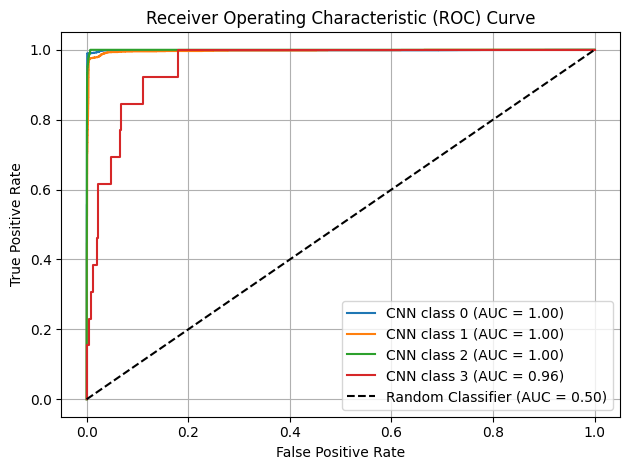

In [32]:
for i in range(len(classes)):
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test_bin[:, i], cnn_pred_proba[:, i])
    plt.plot(fpr_cnn, tpr_cnn, label=f'CNN class {i} (AUC = {roc_auc_score(y_test_bin[:, i], cnn_pred_proba[:, i]):.2f})')

# Đường baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()